# Requirements

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from datetime import datetime

In [2]:
# Suppress warnings for cleaner output.
warnings.filterwarnings('ignore')

# Data

In [3]:
# Download the dataset.
!gdown 1MvbFwYI5S3V7J-9RyvfGTq1eEVyWb_Bt

Downloading...
From: https://drive.google.com/uc?id=1MvbFwYI5S3V7J-9RyvfGTq1eEVyWb_Bt
To: C:\Users\pesev\Desktop\ML in Finance (Data Science)\Forecasting\AGRIDATA.csv

  0%|          | 0.00/6.77M [00:00<?, ?B/s]
  8%|7         | 524k/6.77M [00:00<00:02, 3.12MB/s]
 39%|###8      | 2.62M/6.77M [00:00<00:00, 10.7MB/s]
 70%|######9   | 4.72M/6.77M [00:00<00:00, 13.8MB/s]
100%|##########| 6.77M/6.77M [00:00<00:00, 15.4MB/s]
100%|##########| 6.77M/6.77M [00:00<00:00, 13.3MB/s]


# Analysis

In [4]:
# Define a function for Simple Moving Average (SMA).
def simple_moving_average(series: pd.Series, window_size: int = 1):
    """
    Calculate Simple Moving Average (SMA) for a given time series.

    :param series: Time series data.
    :param window_size: Size of the moving window.
    :return: Series of SMA values.
    """

    averages = []
    for index in range(len(series)):
        if index >= window_size:
            window = series[(index - window_size):index].tolist()
            simple_average = np.average(window)
            averages.append(simple_average)
        else:
            averages.append(None)

    return pd.Series(averages, index=series.index)

In [5]:
# Define a function for Weighted Moving Average (WMA).
def weighted_moving_average(series: pd.Series, window_size: int = 1):
    """
    Calculate Weighted Moving Average (WMA) for a given time series.

    :param series: Time series data.
    :param window_size: Size of the moving window.
    :return: Series of WMA values.
    """

    weights = list(range(1, window_size + 1))
    averages = []
    for index in range(len(series)):
        if index >= window_size:
            window = series[(index - window_size):index].tolist()
            weighted_average = np.average(window, weights=weights)
            averages.append(weighted_average)
        else:
            averages.append(None)

    return pd.Series(averages, index=series.index)

In [6]:
# Read the data from 'AGRIDATA.csv' into a pandas DataFrame.
data_frame = pd.read_csv('AGRIDATA.csv')

In [7]:
data_frame

,Year/Month,Country,Category,Price
0,2003/01,AT,Apples,0.222160
1,2003/02,AT,Apples,0.255440
2,2003/03,AT,Apples,0.210113
3,2003/04,AT,Apples,0.150500
4,2003/05,AT,Apples,0.120820
...,...,...,...,...
290159,2022/09,SK,Wheat,NaN
290160,2022/10,SK,Wheat,NaN
290161,2022/11,SK,Wheat,NaN
290162,2022/12,SK,Wheat,NaN


In [8]:
# Define a mapping of countries to food categories.
mapping = {
    'BE': ['Apples', 'Chicken', 'Milk', 'Pears', 'Pig Meat', 'Tomatoes'],
    'BG': ['Chicken', 'Eggs', 'Pig Meat'],
    'CY': ['Pig Meat'],
    'DE': ['Butter', 'Cheese', 'Eggs', 'Pig Meat'],
    'EL': ['Eggs', 'Milk', 'Olive Oil', 'Pig Meat'],
    'ES': ['Apples', 'Chicken', 'Lemons', 'Milk', 'Pig Meat'],
    'HR': ['Milk', 'Pig Meat'],
    'IT': ['Lemons', 'Tomatoes'],
    'NL': ['Milk', 'Pig Meat'],
    'PL': ['Butter', 'Cheese', 'Chicken', 'Pig Meat'],
    'PT': ['Chicken', 'Pig Meat'],
    'SI': ['Milk', 'Pig Meat']
}

In [9]:
# Define the start and end date for the analysis.
start_date = datetime(2013, 1, 1)
end_date = datetime(2022, 1, 1)

# Generate a list of monthly date strings from start_date to end_date.
dates = []
while start_date <= end_date:
    formatted_date = start_date.strftime('%Y/%m')
    dates.append(formatted_date)
    if start_date.month == 12:
        start_date = datetime(start_date.year + 1, 1, start_date.day)
    else:
        start_date = datetime(start_date.year, start_date.month + 1, start_date.day)

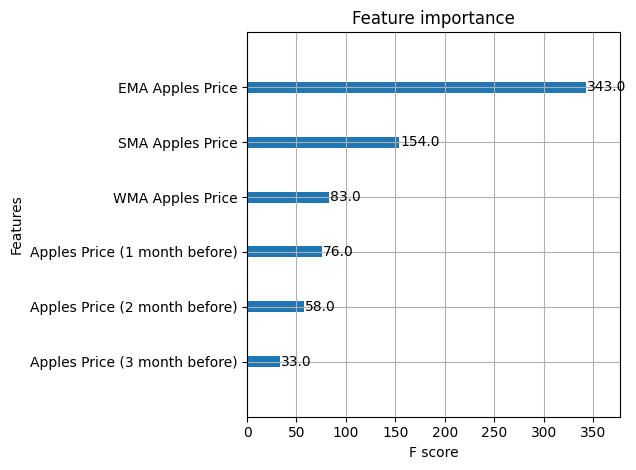

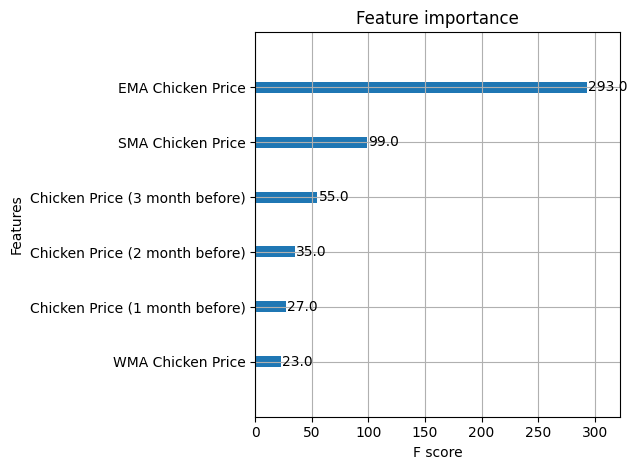

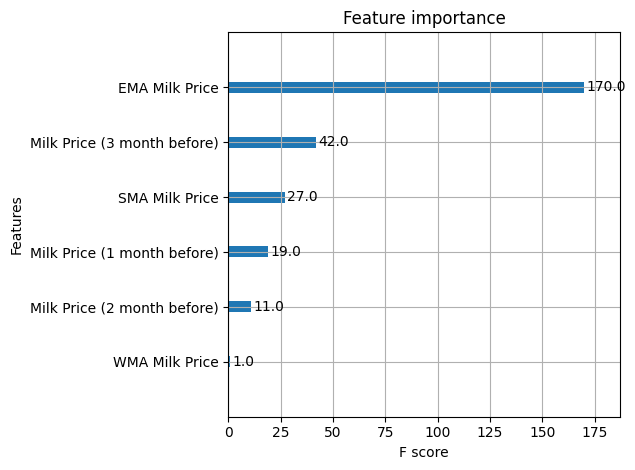

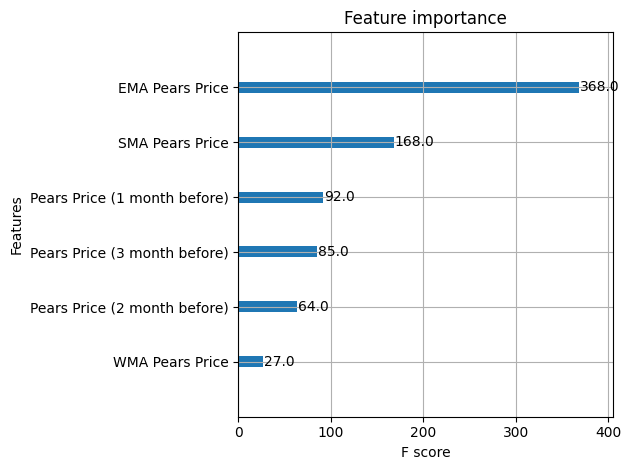

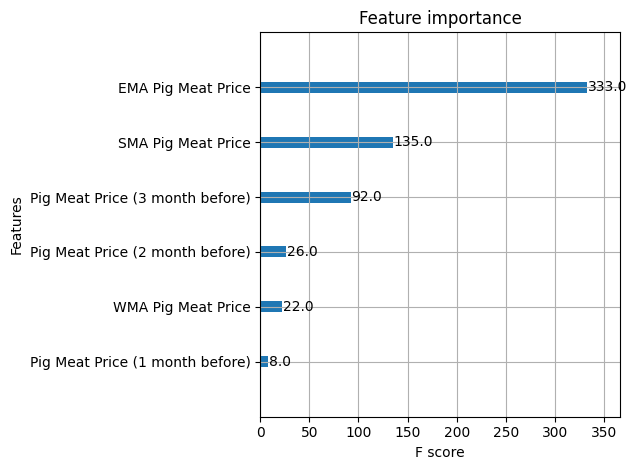

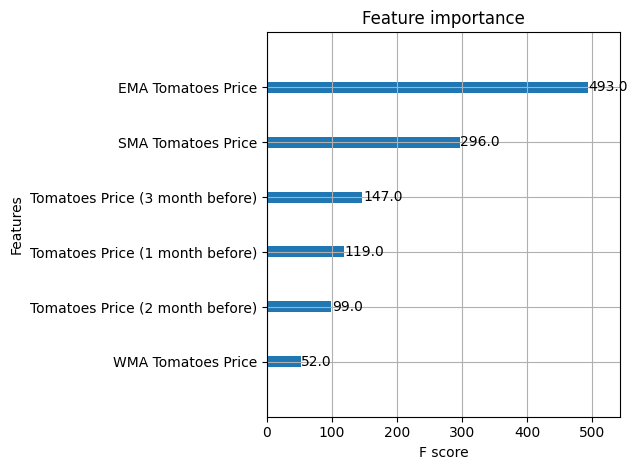

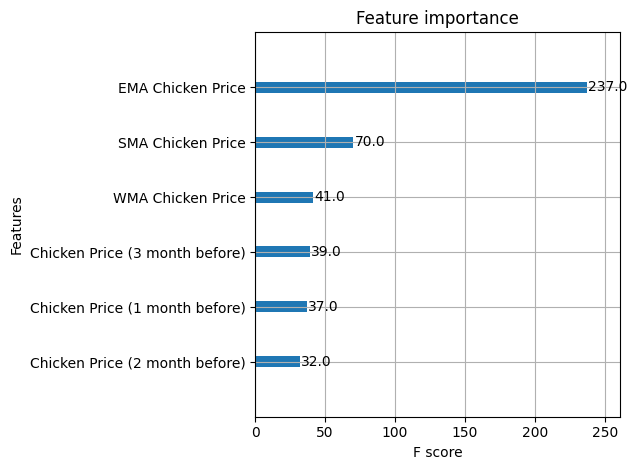

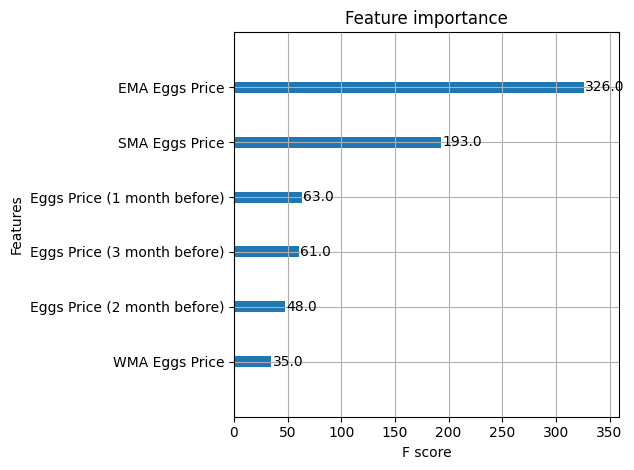

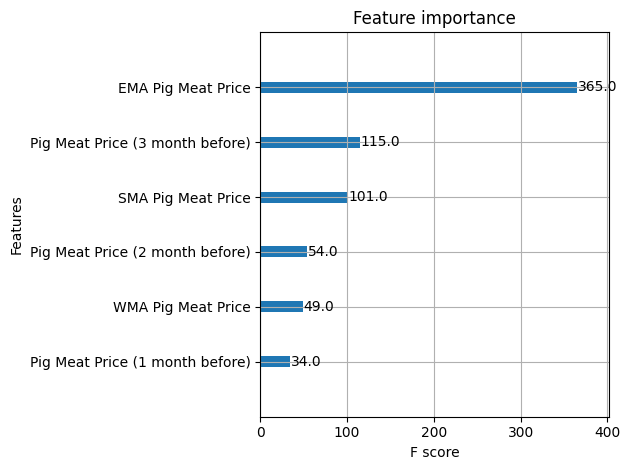

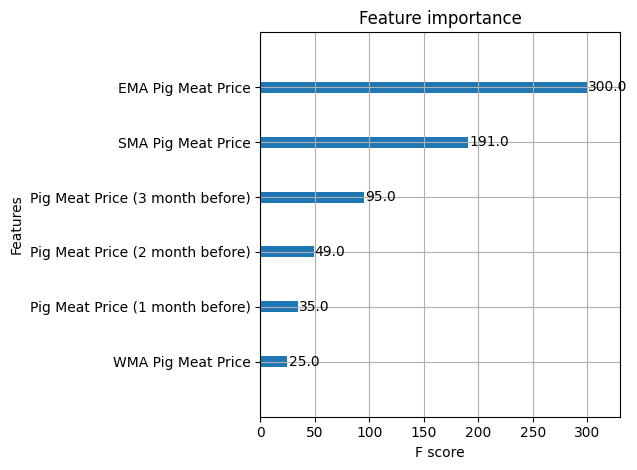

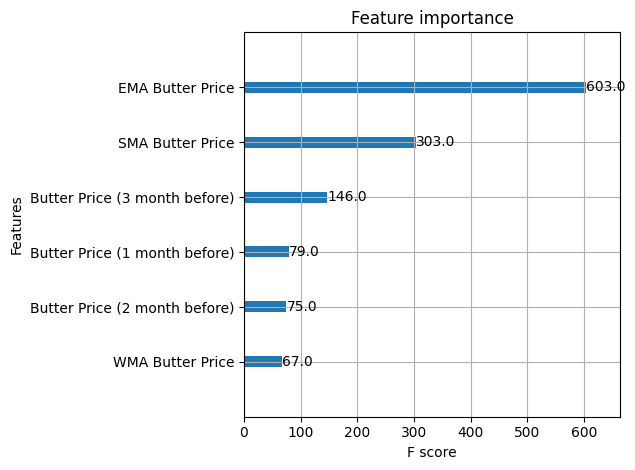

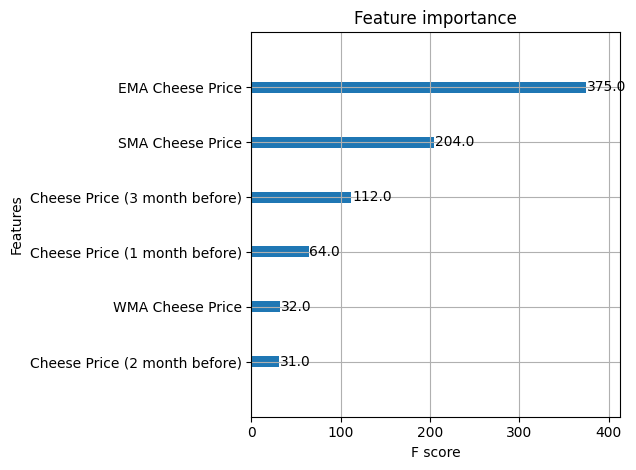

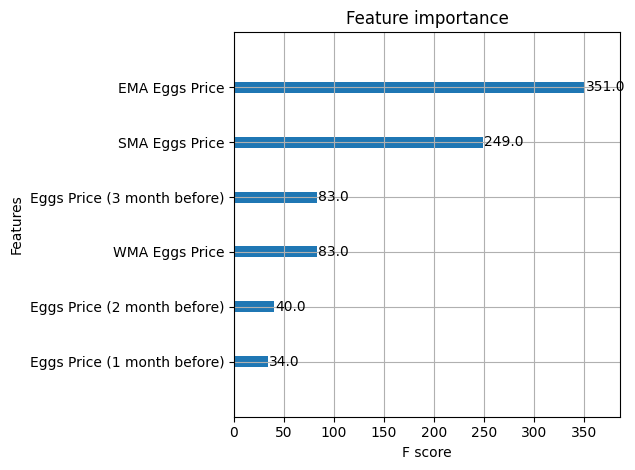

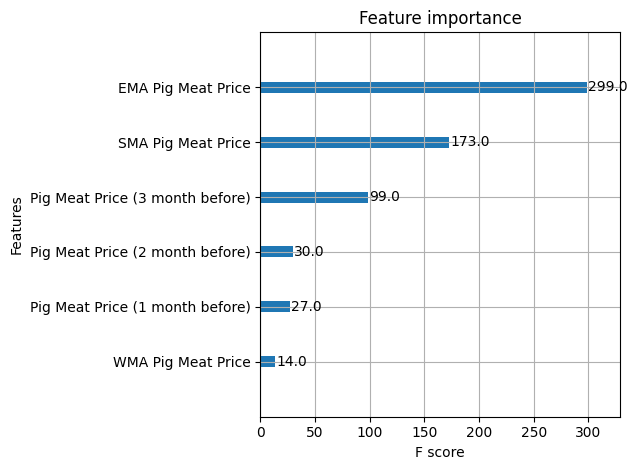

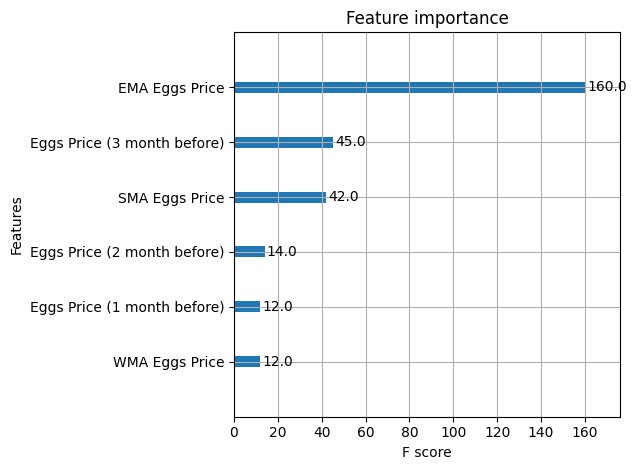

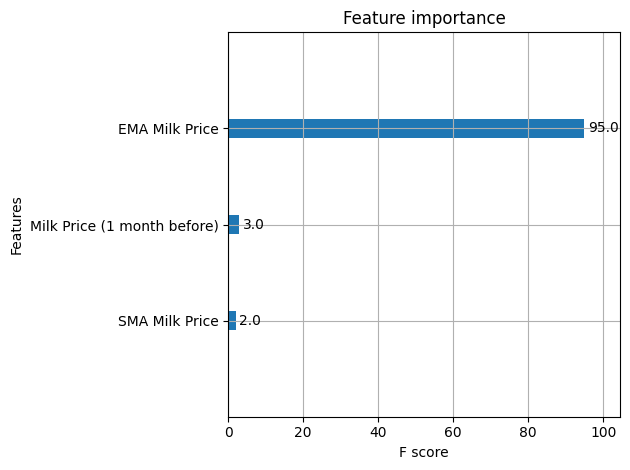

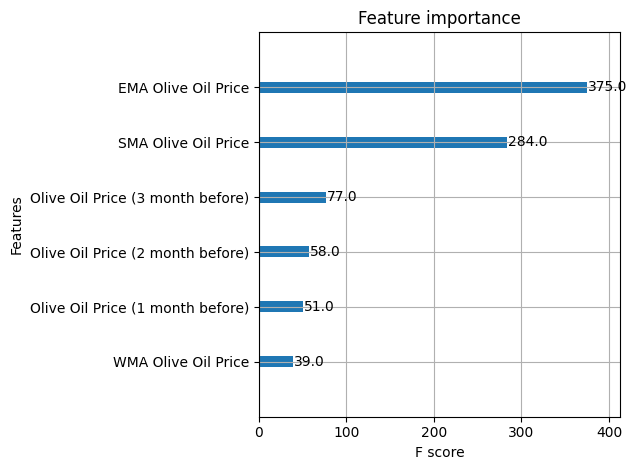

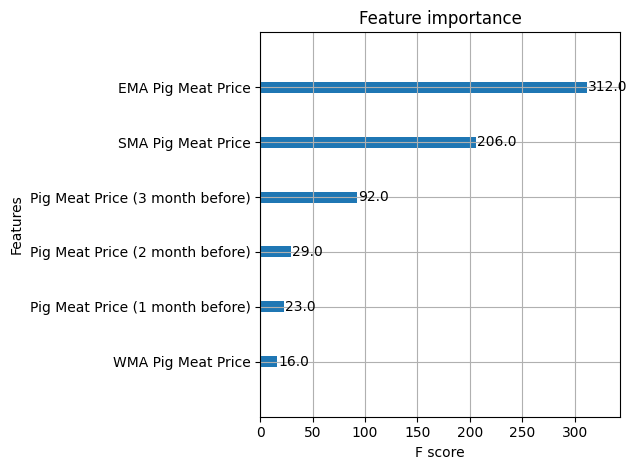

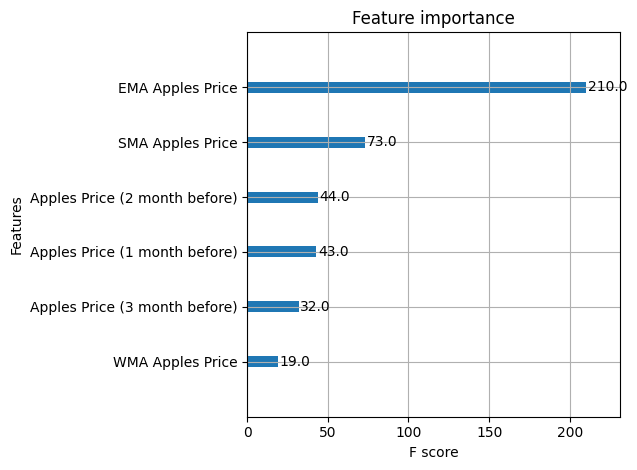

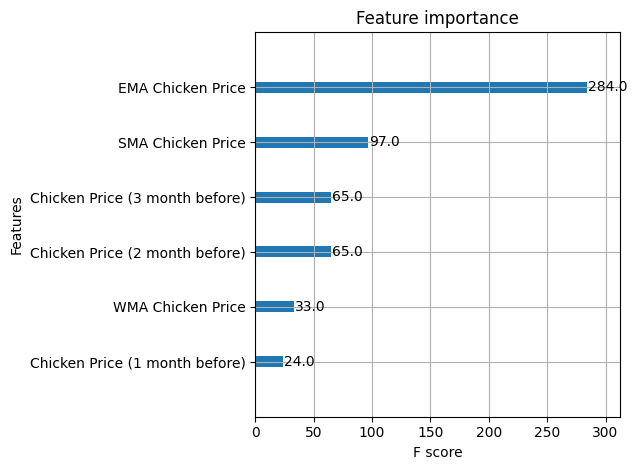

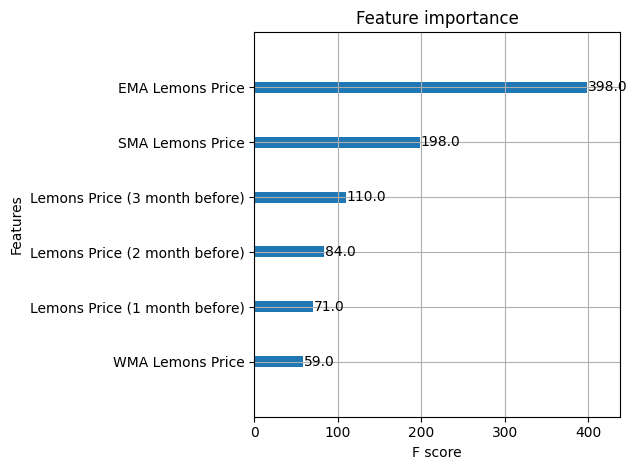

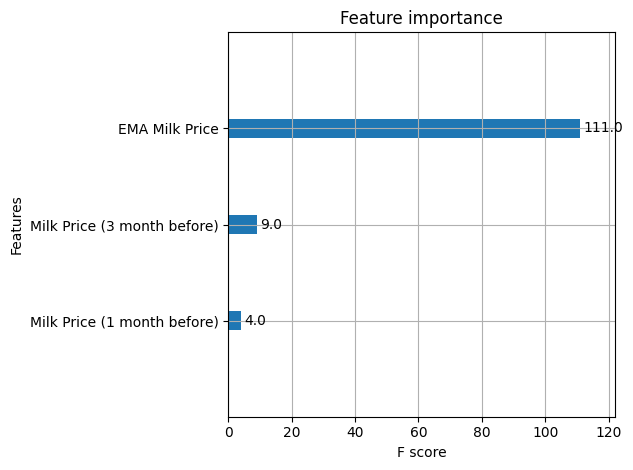

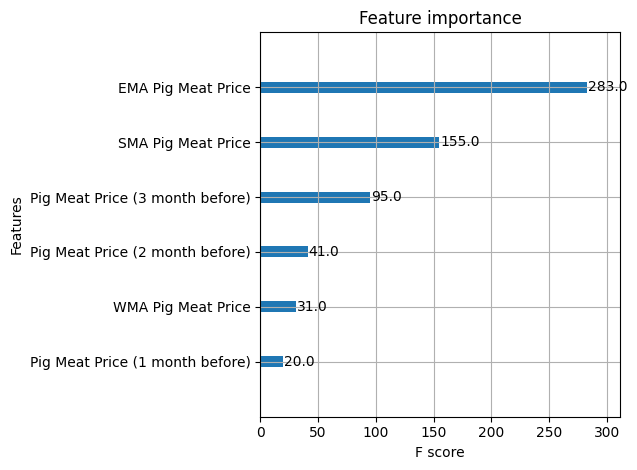

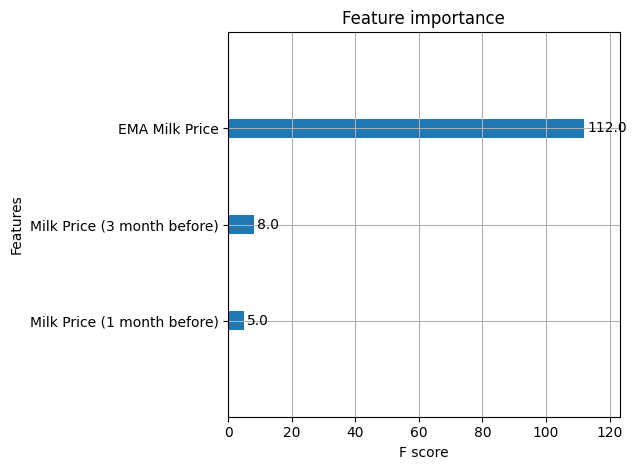

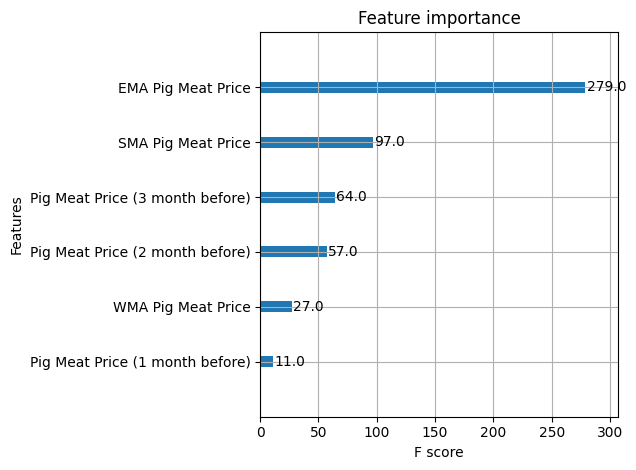

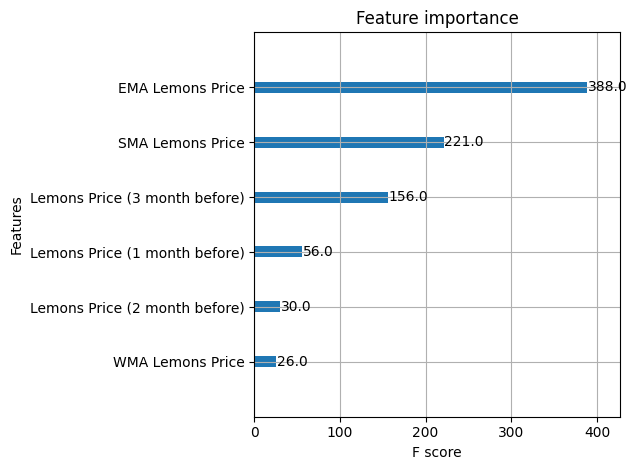

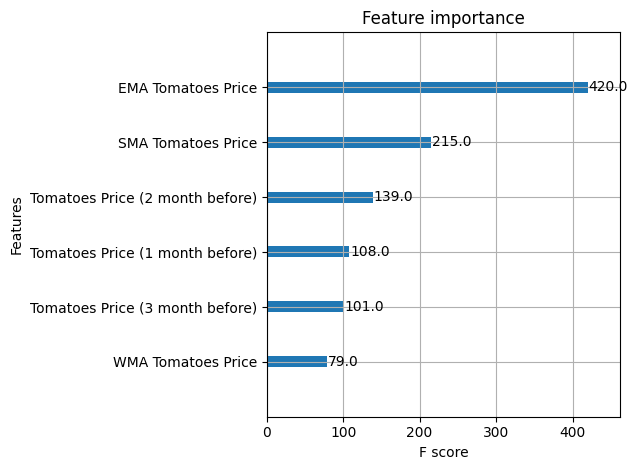

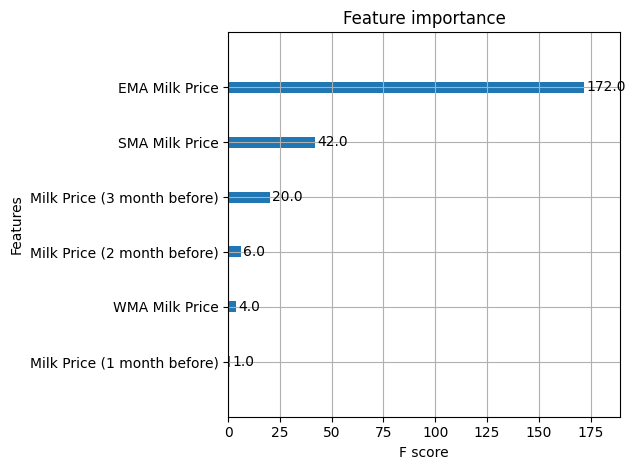

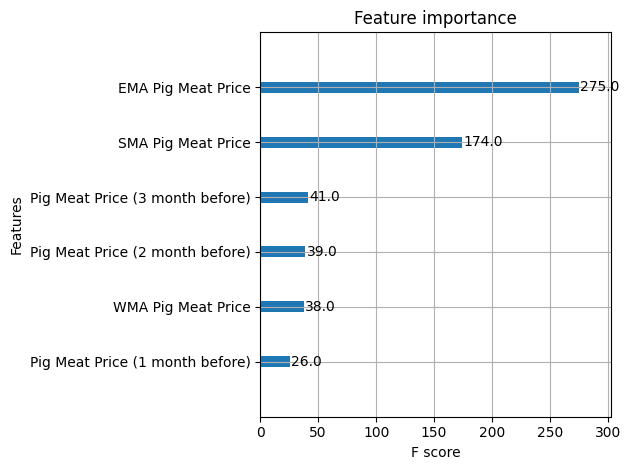

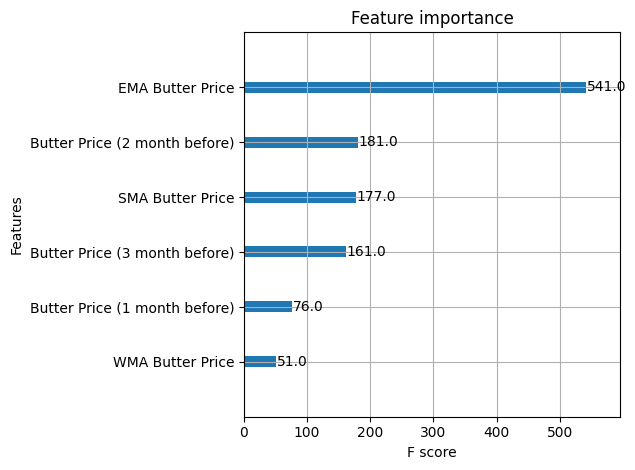

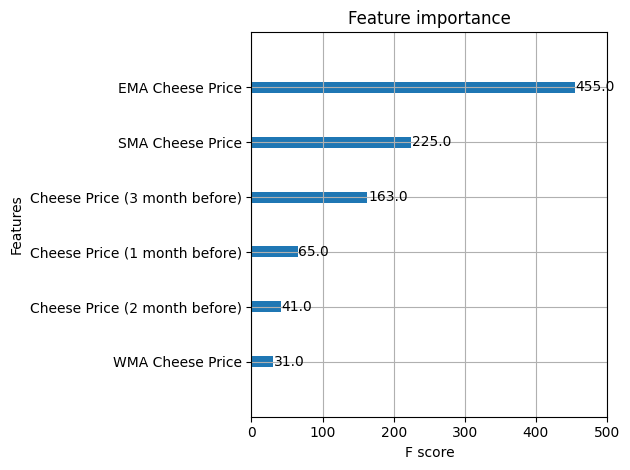

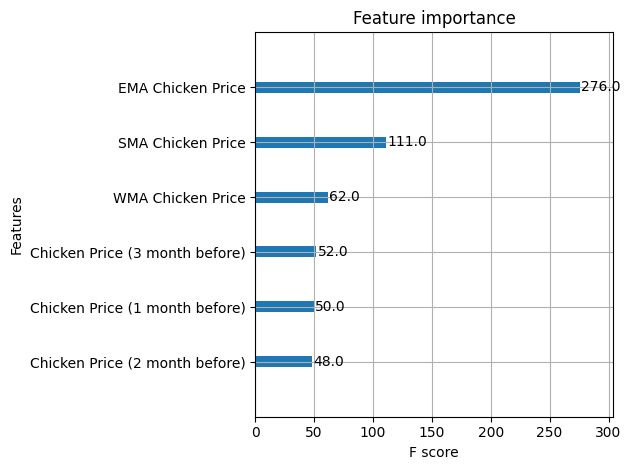

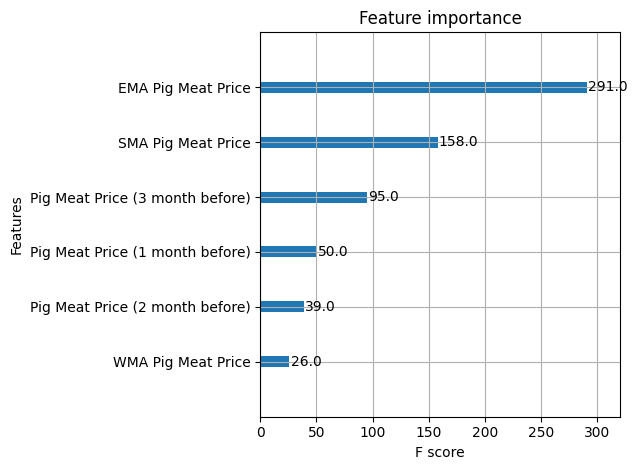

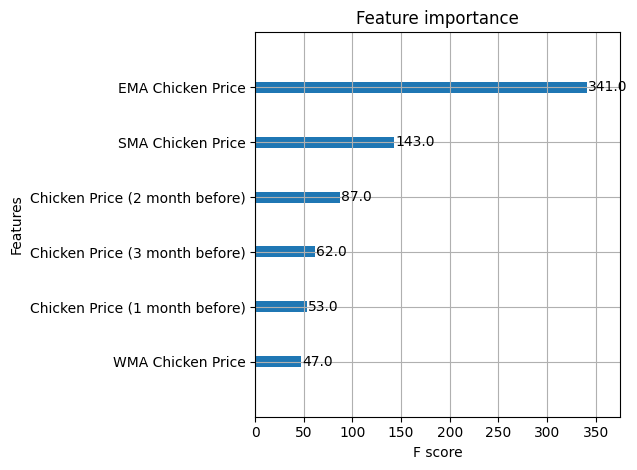

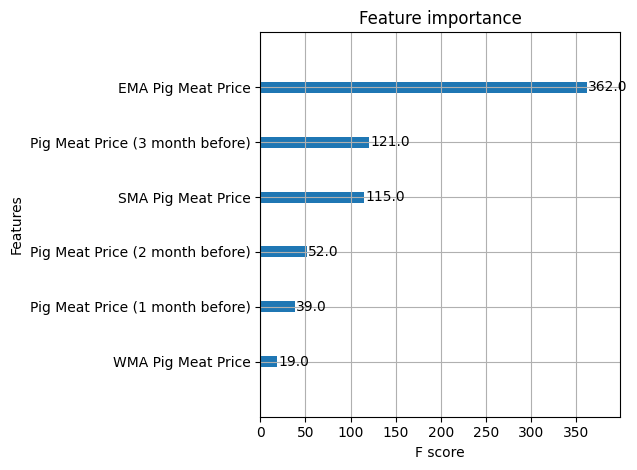

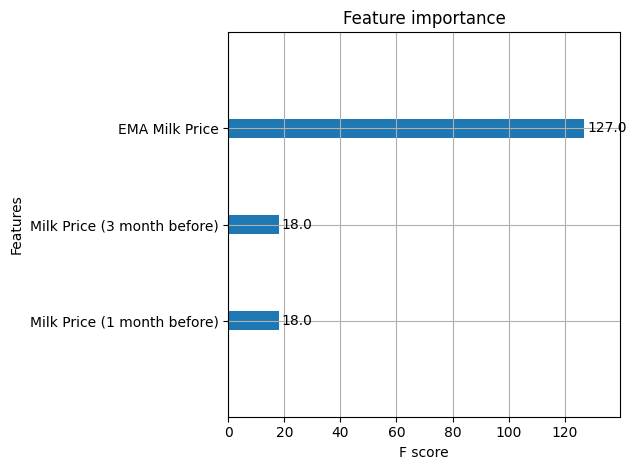

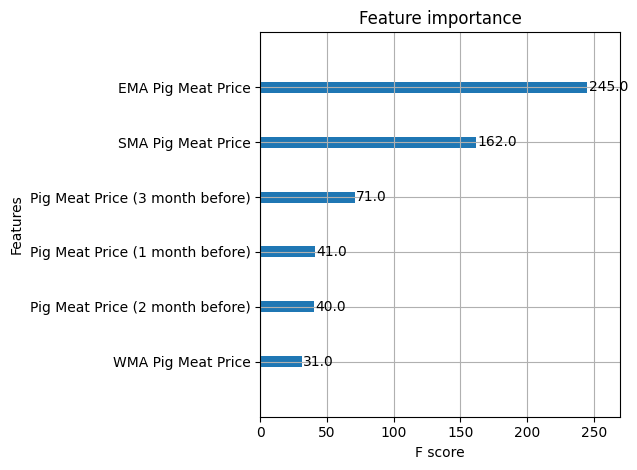

In [10]:
# Define the directory where results will be stored.
directory = 'Results (2013-01 - 2022-01)'

# Iterate through each country in the mapping.
for code in mapping.keys():
    code_directory = os.path.join(directory, code)
    os.makedirs(code_directory, exist_ok=True)

    categories = mapping[code]
    for category in categories:
        category_directory = os.path.join(code_directory, category)
        os.makedirs(category_directory, exist_ok=True)

        # Extract data for the specific country and category within the date range.
        df = data_frame[(data_frame['Year/Month'].isin(dates)) & (data_frame['Country'] == code) & (data_frame['Category'] == category)]

        new_df = pd.DataFrame(columns=['Year/Month', f'{category} Price'])
        new_df['Year/Month'] = dates
        new_df[f'{category} Price'] = df[df['Category'] == category]['Price'].values
        new_df.set_index('Year/Month', inplace=True)

        # Save the count of missing values before filling.
        new_df.isnull().sum().rename('Missing Values').to_csv(os.path.join(category_directory, 'missing-values-before-fill.csv'))

        # Fill missing values with forward and backward fills.
        new_df.ffill(inplace=True)
        new_df.bfill(inplace=True)

        # Save the count of missing values after filling.
        new_df.isnull().sum().rename('Missing Values').to_csv(os.path.join(category_directory, 'missing-values-after-fill.csv'))

        # Calculate the SMA, WMA and EMA, and extract the lagged features (prices from 1, 2, and 3 months ago).
        column = f'{category} Price'
        new_df[f'SMA {column}'] = simple_moving_average(new_df[column], window_size=3)
        new_df[f'WMA {column}'] = weighted_moving_average(new_df[column], window_size=3)
        new_df[f'EMA {column}'] = new_df[column].ewm(span=3, adjust=False).mean()
        new_df[f'{column} ({1} month before)'] = new_df[column].shift(1)
        new_df[f'{column} ({2} month before)'] = new_df[column].shift(2)
        new_df[f'{column} ({3} month before)'] = new_df[column].shift(3)

        # Remove rows with missing values.
        new_df.dropna(axis=0, inplace=True)

        # Split the data into training and testing sets.
        X = new_df.drop(column, axis=1)
        Y = new_df[column]
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=25 / 106, random_state=0, shuffle=False)

        # Save training and testing datasets.
        X_train.join(Y_train).to_csv(os.path.join(category_directory, 'train-dataset.csv'))
        X_test.join(Y_test).to_csv(os.path.join(category_directory, 'test-dataset.csv'))

        # Train an XGBoost regression model.
        model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, gamma=0.0001, objective='reg:squarederror')
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)

        # Save model evaluation metrics in a log file.
        with open(os.path.join(category_directory, 'logs.txt'), 'w') as file:
            file.writelines([
                f'R^2 score: {r2_score(Y_test, y_pred)}\n',
                f'Mean squared error: {mean_squared_error(Y_test, y_pred)}\n',
                f'Mean absolute error: {mean_absolute_error(Y_test, y_pred)}\n'
            ])

        # Calculate baseline model metrics (using the previous month's value).
        with open(os.path.join(category_directory, 'baseline_model_logs.txt'), 'w') as file:
            file.writelines([
                f'R^2 score: {r2_score(Y_test, X_test[f"{column} (1 month before)"])}\n',
                f'Mean squared error: {mean_squared_error(Y_test, X_test[f"{column} (1 month before)"])}\n',
                f'Mean absolute error: {mean_absolute_error(Y_test, X_test[f"{column} (1 month before)"])}\n'
            ])

        # Create a plot of actual vs. predicted values.
        fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
        ax.plot(Y_test.index, Y_test, label=f'Actual {column}', color='blue')
        ax.plot(Y_test.index, y_pred, label=f'Predicted {column}', color='green')
        plt.title(f'{column} (Actual vs. Predicted)')
        plt.xticks(rotation=90)
        ax.set_xticks(Y_test.index.tolist())
        ax.set_xticklabels(Y_test.index.tolist())
        ax.legend(loc='upper left')
        plt.tight_layout()

        # Save the plot as an image.
        plt.savefig(os.path.join(category_directory, 'plot.png'))
        plt.close(fig)

        # Save feature importance information.
        with open(os.path.join(category_directory, 'features_importance.txt'), 'w') as file:
            file.write(str(model.get_booster().get_score(importance_type='weight')))

        # Create a plot of feature importance.
        figure = plt.figure(figsize=(12, 6), dpi=100)
        plot_importance(model)
        plt.tight_layout()

        # Save the feature importance plot as an image.
        plt.savefig(os.path.join(category_directory, 'importance.png'))
        plt.close(fig=figure)

In [11]:
# Repeat the same process for a different date range ('2013-01' to '2023-01').
start_date = datetime(2013, 1, 1)
end_date = datetime(2023, 1, 1)

dates = []
while start_date <= end_date:
    formatted_date = start_date.strftime('%Y/%m')
    dates.append(formatted_date)
    if start_date.month == 12:
        start_date = datetime(start_date.year + 1, 1, start_date.day)
    else:
        start_date = datetime(start_date.year, start_date.month + 1, start_date.day)

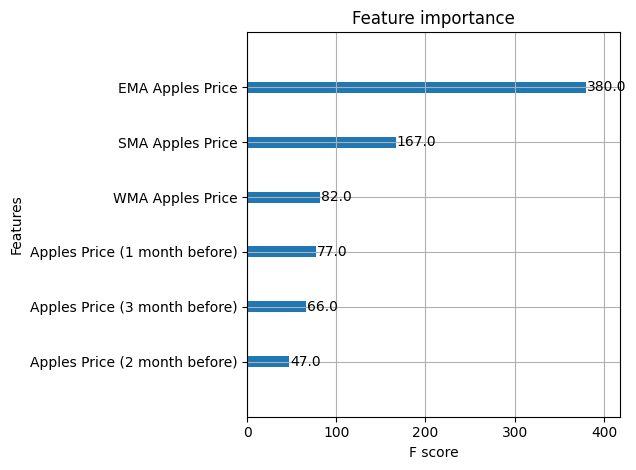

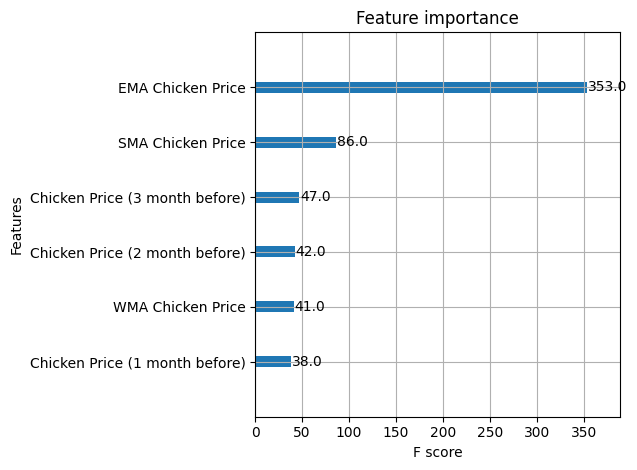

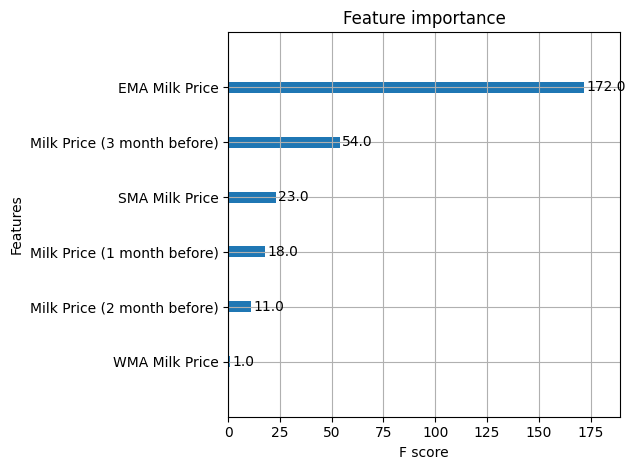

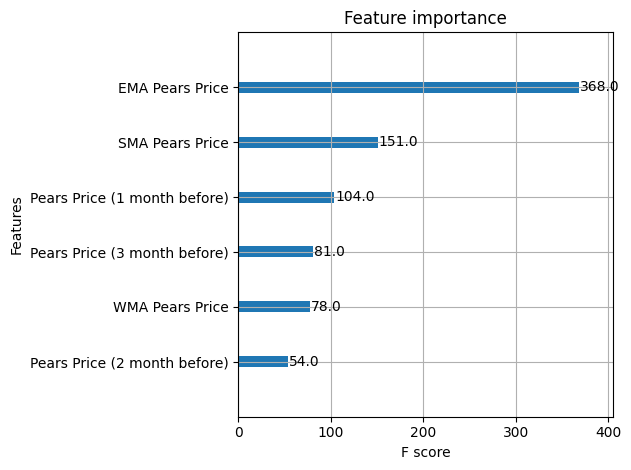

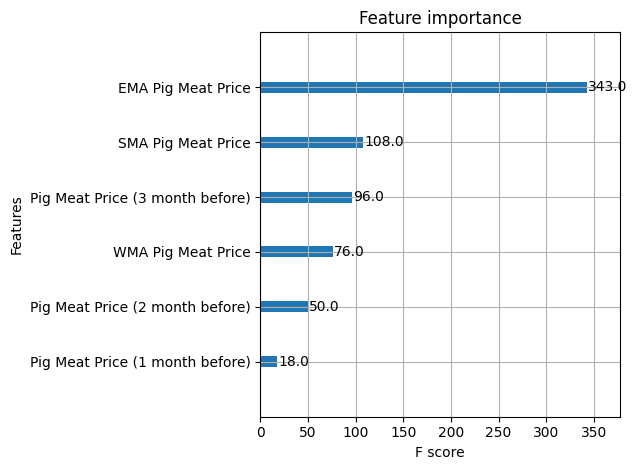

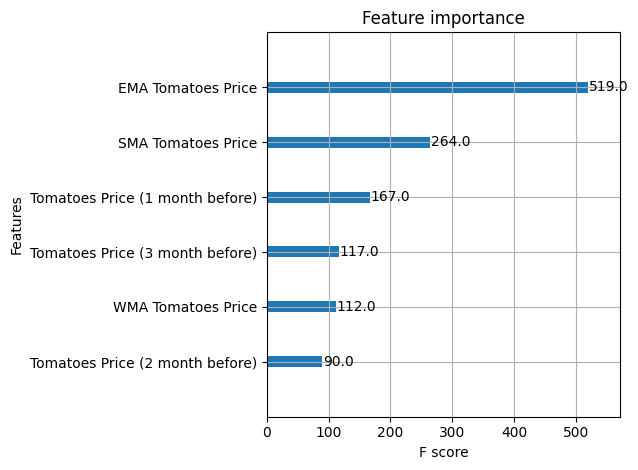

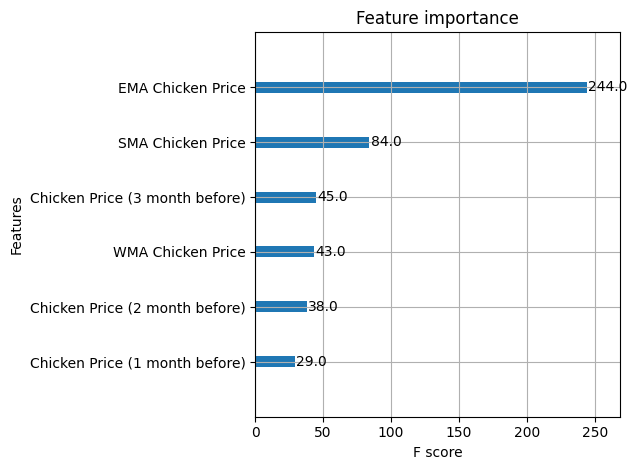

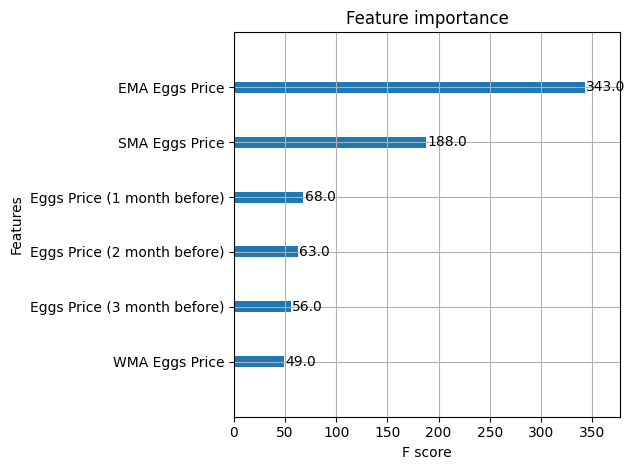

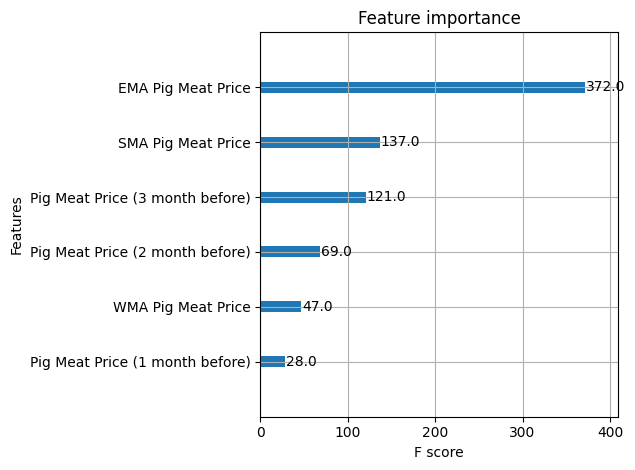

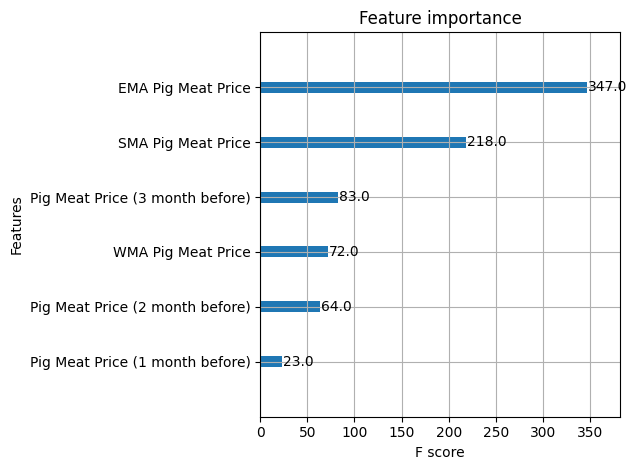

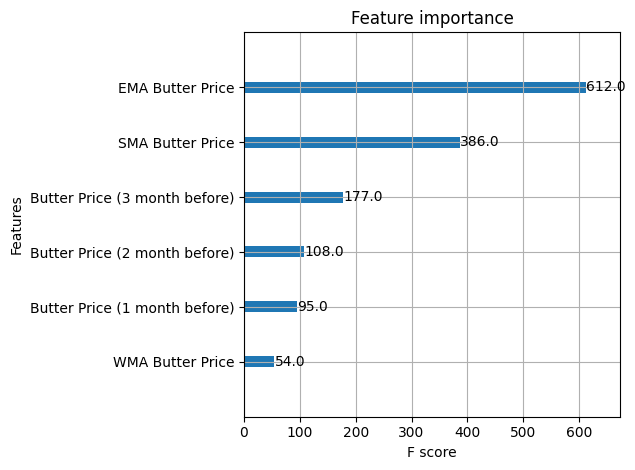

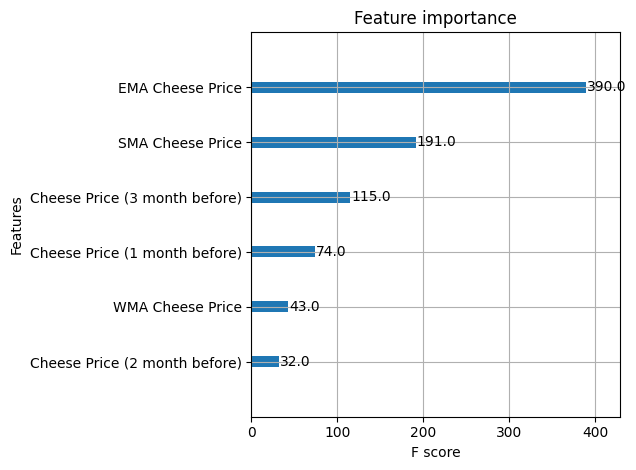

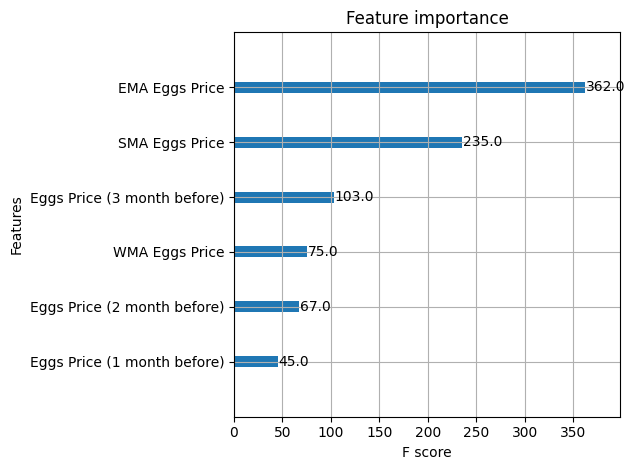

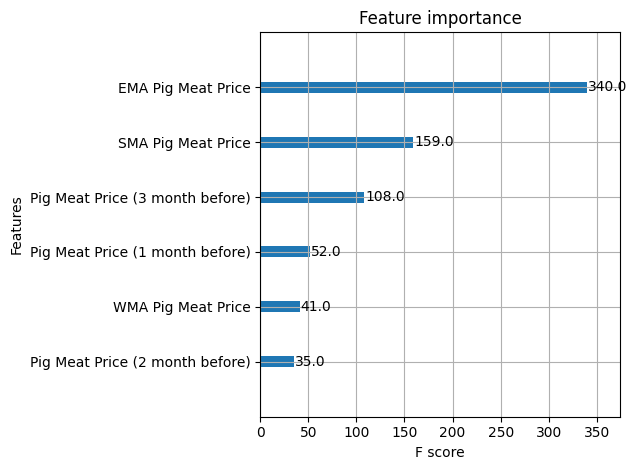

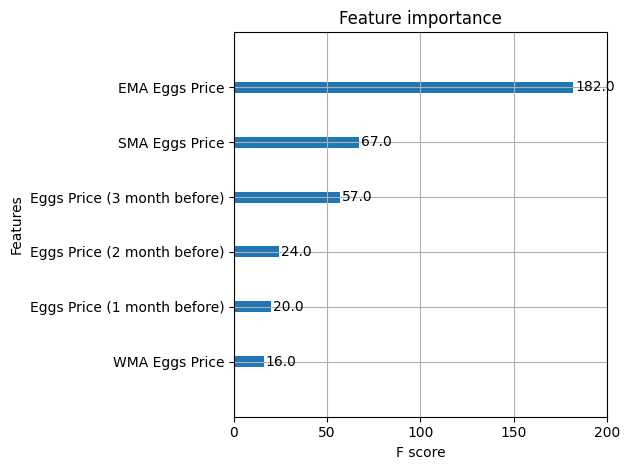

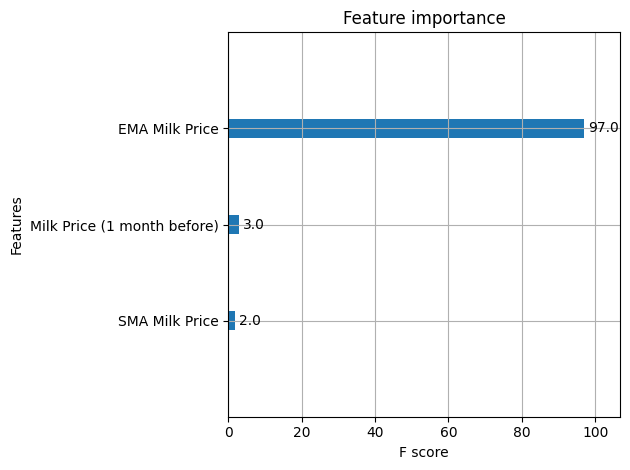

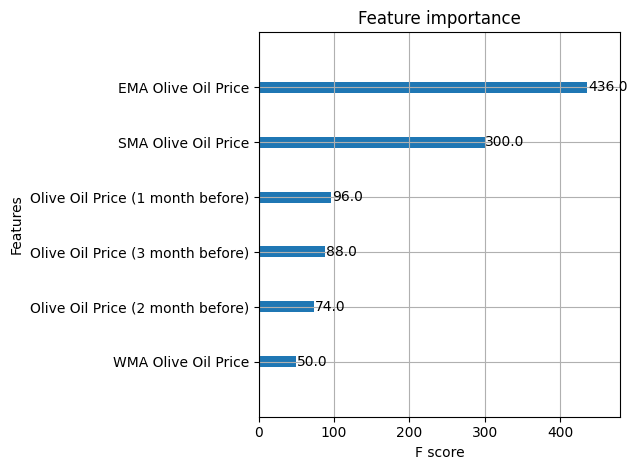

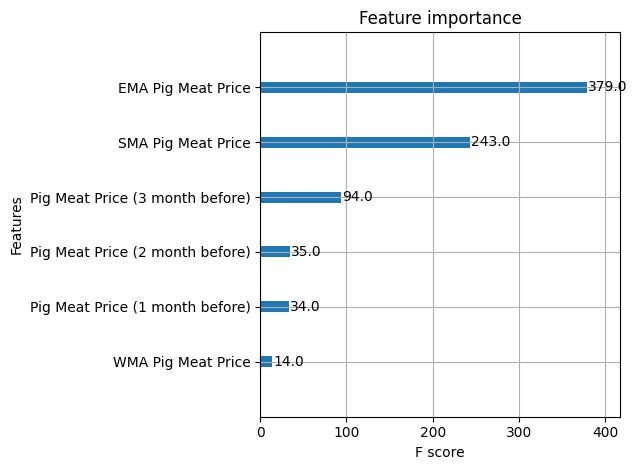

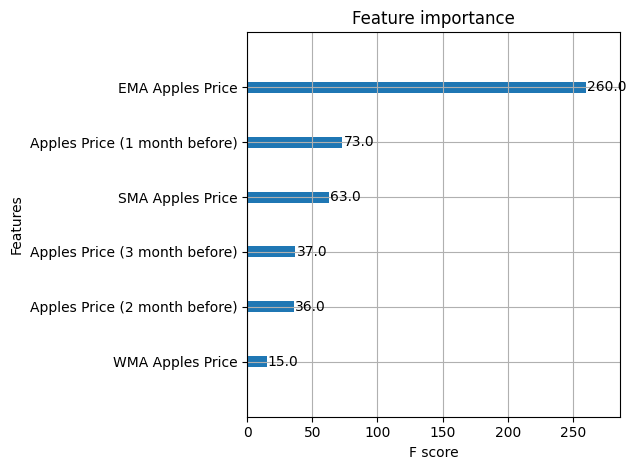

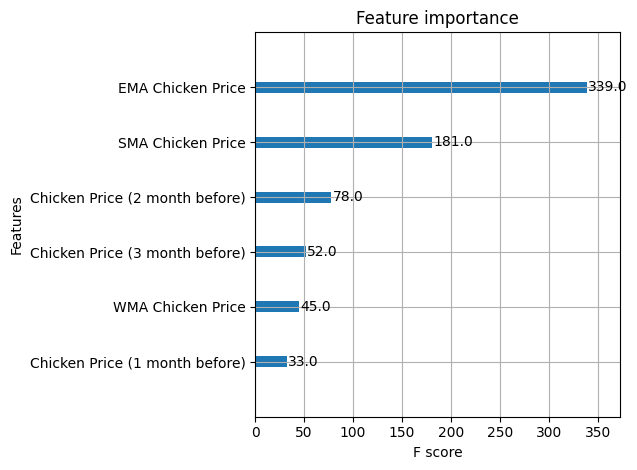

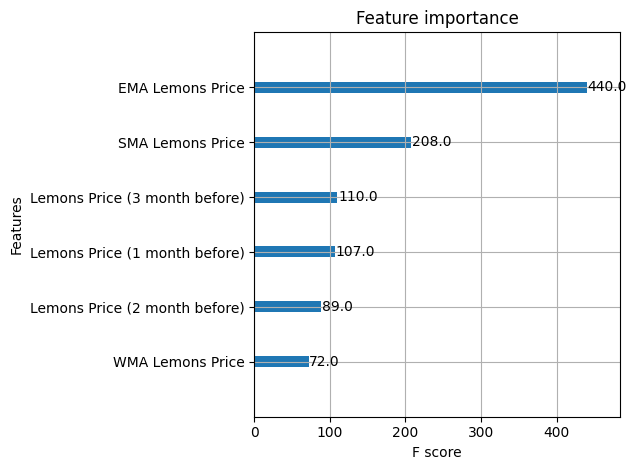

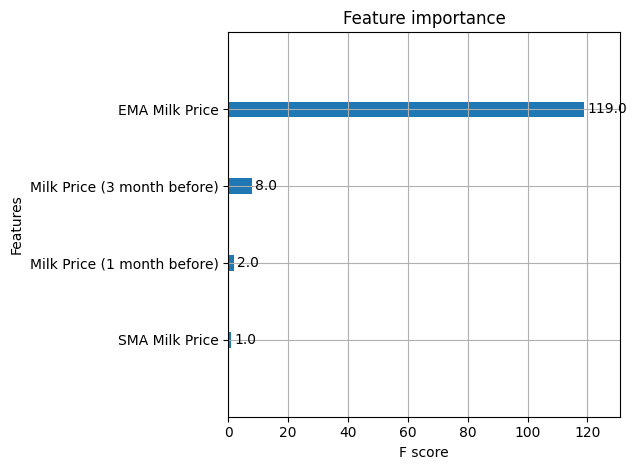

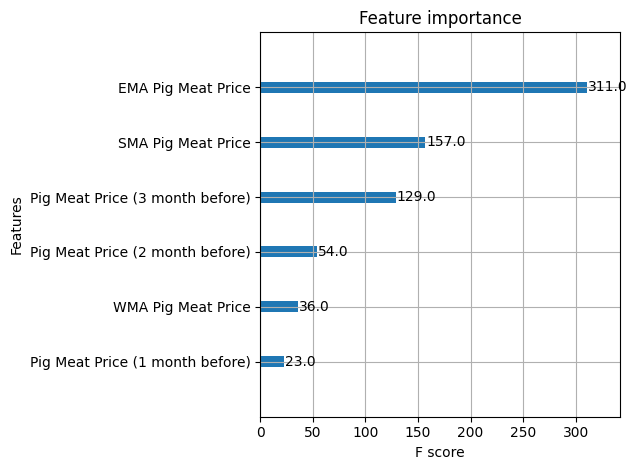

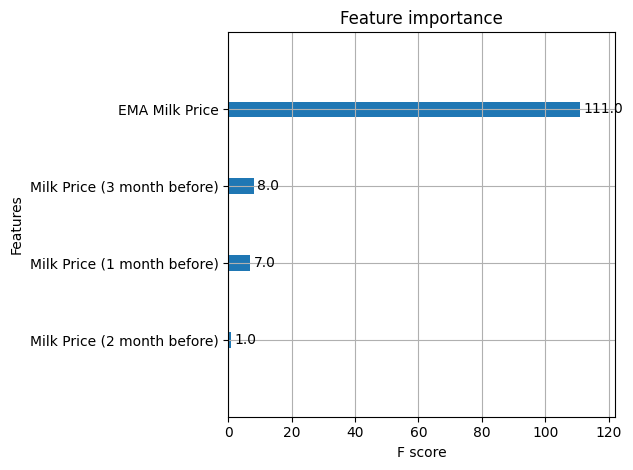

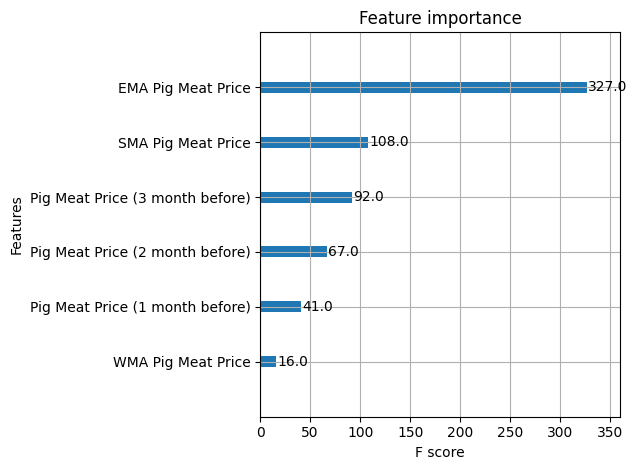

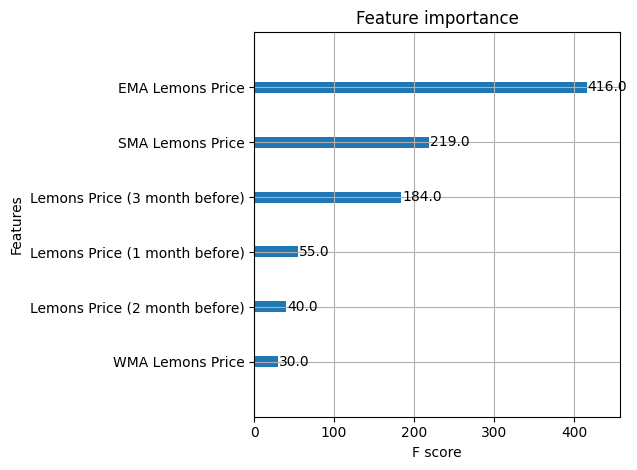

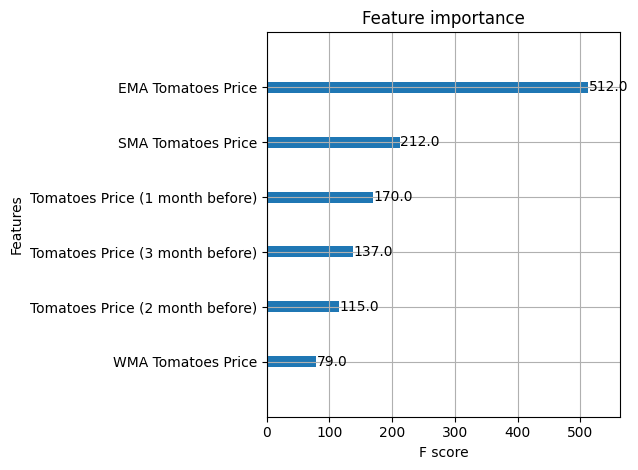

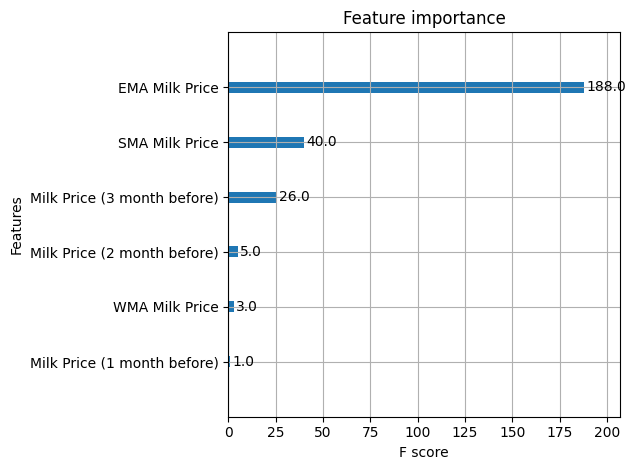

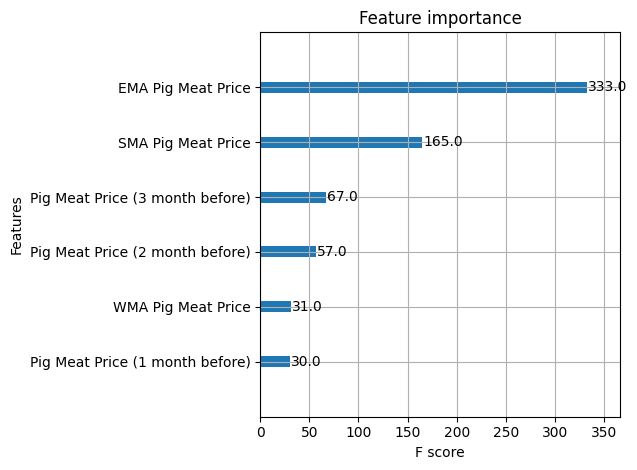

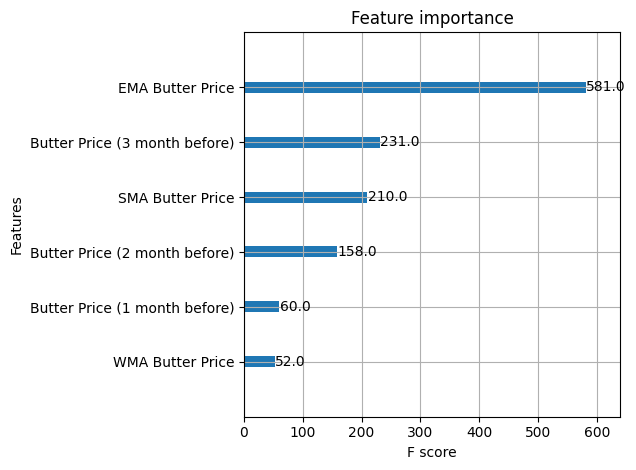

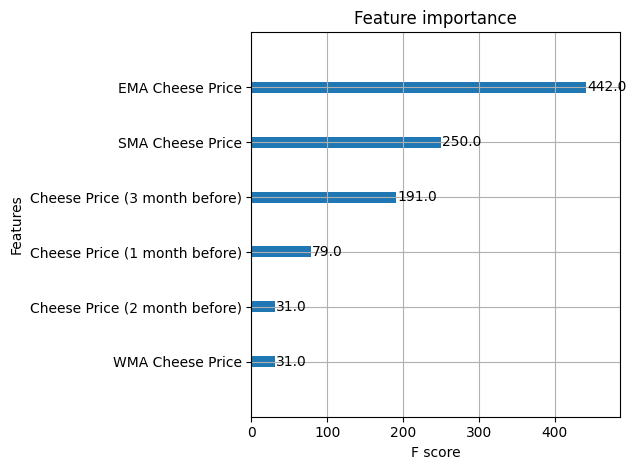

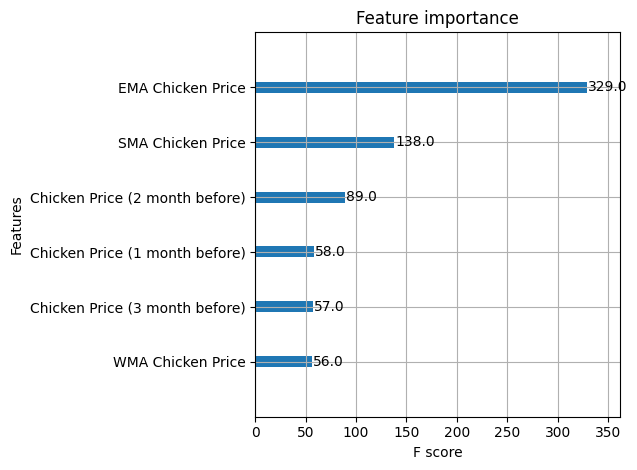

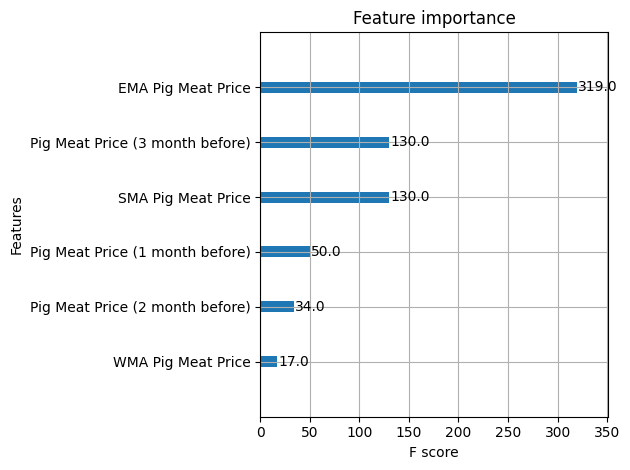

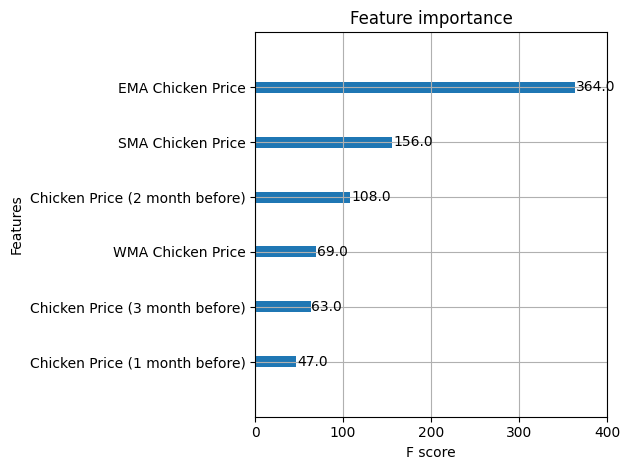

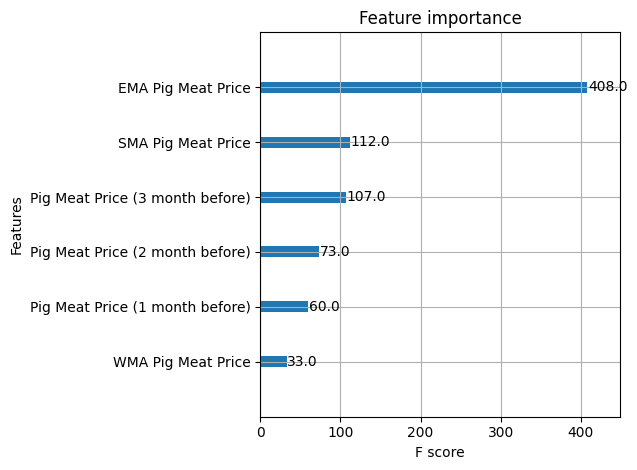

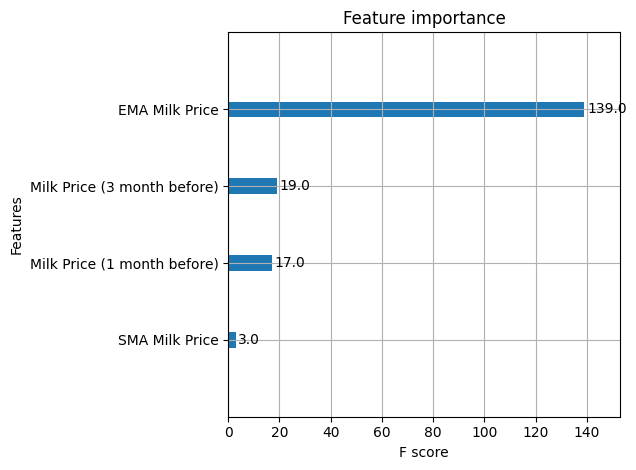

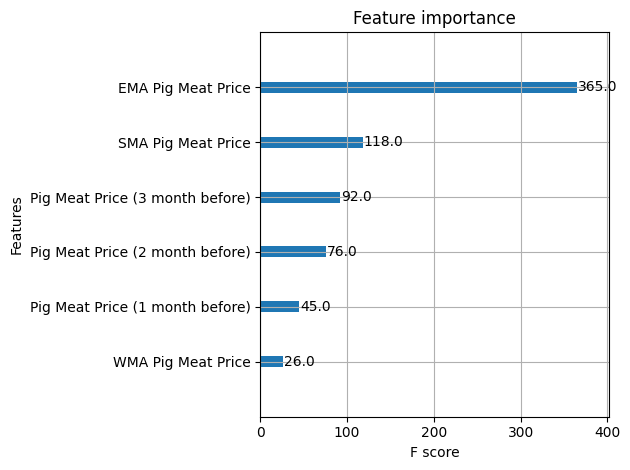

In [12]:
directory = 'Results (2013-01 - 2023-01)'
for code in mapping.keys():
    code_directory = os.path.join(directory, code)
    os.makedirs(code_directory, exist_ok=True)

    categories = mapping[code]
    for category in categories:
        category_directory = os.path.join(code_directory, category)
        os.makedirs(category_directory, exist_ok=True)

        df = data_frame[(data_frame['Year/Month'].isin(dates)) & (data_frame['Country'] == code) & (data_frame['Category'] == category)]

        new_df = pd.DataFrame(columns=['Year/Month', f'{category} Price'])
        new_df['Year/Month'] = dates
        new_df[f'{category} Price'] = df[df['Category'] == category]['Price'].values
        new_df.set_index('Year/Month', inplace=True)

        new_df.isnull().sum().rename('Missing Values').to_csv(os.path.join(category_directory, 'missing-values-before-fill.csv'))

        new_df.ffill(inplace=True)
        new_df.bfill(inplace=True)

        new_df.isnull().sum().rename('Missing Values').to_csv(os.path.join(category_directory, 'missing-values-after-fill.csv'))

        column = f'{category} Price'
        new_df[f'SMA {column}'] = simple_moving_average(new_df[column], window_size=3)
        new_df[f'WMA {column}'] = weighted_moving_average(new_df[column], window_size=3)
        new_df[f'EMA {column}'] = new_df[column].ewm(span=3, adjust=False).mean()
        new_df[f'{column} ({1} month before)'] = new_df[column].shift(1)
        new_df[f'{column} ({2} month before)'] = new_df[column].shift(2)
        new_df[f'{column} ({3} month before)'] = new_df[column].shift(3)

        new_df.dropna(axis=0, inplace=True)

        X = new_df.drop(column, axis=1)
        Y = new_df[column]
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=25 / 118, random_state=0, shuffle=False)

        X_train.join(Y_train).to_csv(os.path.join(category_directory, 'train-dataset.csv'))
        X_test.join(Y_test).to_csv(os.path.join(category_directory, 'test-dataset.csv'))

        model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, gamma=0.0001, objective='reg:squarederror')
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)

        with open(os.path.join(category_directory, 'logs.txt'), 'w') as file:
            file.writelines([
                f'R^2 score: {r2_score(Y_test, y_pred)}\n',
                f'Mean squared error: {mean_squared_error(Y_test, y_pred)}\n',
                f'Mean absolute error: {mean_absolute_error(Y_test, y_pred)}\n'
            ])

        with open(os.path.join(category_directory, 'baseline_model_logs.txt'), 'w') as file:
            file.writelines([
                f'R^2 score: {r2_score(Y_test, X_test[f"{column} (1 month before)"])}\n',
                f'Mean squared error: {mean_squared_error(Y_test, X_test[f"{column} (1 month before)"])}\n',
                f'Mean absolute error: {mean_absolute_error(Y_test, X_test[f"{column} (1 month before)"])}\n'
            ])

        fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
        ax.plot(Y_test.index, Y_test, label=f'Actual {column}', color='blue')
        ax.plot(Y_test.index, y_pred, label=f'Predicted {column}', color='green')
        plt.title(f'{column} (Actual vs. Predicted)')
        plt.xticks(rotation=90)
        ax.set_xticks(Y_test.index.tolist())
        ax.set_xticklabels(Y_test.index.tolist())
        ax.legend(loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(category_directory, 'plot.png'))
        plt.close(fig)

        with open(os.path.join(category_directory, 'features_importance.txt'), 'w') as file:
            file.write(str(model.get_booster().get_score(importance_type='weight')))

        figure = plt.figure(figsize=(12, 6), dpi=100)
        plot_importance(model)
        plt.tight_layout()
        plt.savefig(os.path.join(category_directory, 'importance.png'))
        plt.close(fig=figure)